In [1]:
%load_ext autoreload
%autoreload 2

import sys

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(os.cpu_count())
#print(os.environ['CUDA_VISIBLE_DEVICES'])

#seed = 1234
#fix_seed(seed)


import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader

#sys.path.append("../")

from scarf.loss import NTXent
from scarf.model import SCARF, MLP, SCARF_modified
from cancerclassification.data import *
from cancerclassification.NN import *

from example.dataset import ExampleDataset
from example.utils import dataset_embeddings, fix_seed, train_epoch


56


# Load Data

In [2]:
x_unlabel = read_process_data_TCGA_unlabel('../data/TCGA/pretrain_data.parquet')
train_dataset = read_process_data_TCGA('../data/TCGA/train_data.parquet', '../data/TCGA/label.parquet')
test_dataset = read_process_data_TCGA('../data/TCGA/test_data.parquet', '../data/TCGA/label.parquet')

Index(['cancer_type', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       ...
       'ENSG00000288658', 'ENSG00000288659', 'ENSG00000288660',
       'ENSG00000288662', 'ENSG00000288663', 'ENSG00000288667',
       'ENSG00000288669', 'ENSG00000288670', 'ENSG00000288674',
       'ENSG00000288675'],
      dtype='object', length=56903)
Index(['cancer_type', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       ...
       'ENSG00000288658', 'ENSG00000288659', 'ENSG00000288660',
       'ENSG00000288662', 'ENSG00000288663', 'ENSG00000288667',
       'ENSG00000288669', 'ENSG00000288670', 'ENSG00000288674',
       'ENSG00000288675'],
      dtype='object', length=56903)


In [3]:
print('Dimensions')
print(f'Pre-train unlabeled set : {x_unlabel.shape}')
print(f'Training set : {train_dataset.shape}')  # one row for labels
print(f'Test set : {test_dataset.shape}') 
print(f'Number of classes : {len(np.unique(train_dataset[:,0]))}')

Dimensions
Pre-train unlabeled set : (7281, 56902)
Training set : (1039, 56903)
Test set : (1029, 56903)
Number of classes : 19


In [4]:
x_train, y_train = train_dataset[:,1:], train_dataset[:,0]
x_test, y_test = test_dataset[:,1:], test_dataset[:,0]
x_test.shape, x_train.shape, y_test.shape, y_train.shape

((1029, 56902), (1039, 56902), (1029,), (1039,))

# SCARF Training

In [ ]:
corruption_rate = 0.5
dropout = 0.1
batch_size = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_loader = DataLoader(x_unlabel, batch_size=batch_size, shuffle=True)

# build model
model = SCARF(
    input_dim=x_unlabel.shape[1],
    emb_dim=1024, # 16 by default, augment in the future
    features_low=x_unlabel.min(axis=0),
    features_high=x_unlabel.max(axis=0),
    nb_classes=len(np.unique(train_dataset[:,0])),
    corruption_rate=corruption_rate,
    dropout=dropout
).to(device)

In [ ]:
# Training
import time
epochs = 1000

optimizer = Adam(model.parameters(), lr = 1e-3, weight_decay=1e-4)
ntxent_loss = NTXent()

loss_history = []

start = time.time()
for epoch in range(1, epochs+1) :
    epoch_loss = train_epoch(model, ntxent_loss, train_loader, optimizer, device)
    loss_history.append(epoch_loss)
    
    if epoch % 10 == 0 :
        print(f'Epoch {epoch}/{epochs} : loss = {loss_history[-1]}')
        # save model as .pt
        torch.save(model.state_dict(), 'saved_models/scarf_encoder_1024_statedict_1000epochs.pt')

end = time.time()
print(end-start)

In [11]:
(end-start)/60

415.74205752213794

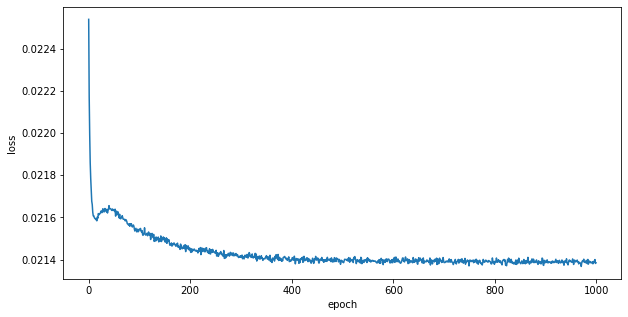

In [12]:
# plot 
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
plt.plot()

plt.savefig("loss_1024emb_1000epochs.png")

# Pre-training with different encoder size and embedding dimensions

In [5]:
corruption_rate = 0.5
dropout = 0.1
batch_size = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_loader = DataLoader(x_unlabel, batch_size=batch_size, shuffle=True)

cuda


In [36]:
dict_test = {}
a, b = 1, 2
dict_test[f"(enc_size : {a}, emb_size : {b}"] = 0.99

In [ ]:
import time

#emb_size_list = [1024, 512, 128, 64]
emb_size_list = [512, 128, 64, 32]
#encoder_size_list = [4, 5, 6, 7, 8, 9, 10]
encoder_size_list = [4]

epochs = 1000
loss_history_dict = {}
time_list = []

for emb_size in emb_size_list :
    for encoder_size in encoder_size_list :
        loss_history = []
        
        # build model
        model = SCARF(
            input_dim=x_unlabel.shape[1],
            emb_dim=emb_size, # 16 by default
            features_low=x_unlabel.min(axis=0),
            features_high=x_unlabel.max(axis=0),
            nb_classes=len(np.unique(train_dataset[:,0])),
            num_hidden=encoder_size,
            corruption_rate=corruption_rate,
            dropout=dropout
        ).to(device)
        
        optimizer = Adam(model.parameters(), lr = 1e-3, weight_decay=1e-4)
        ntxent_loss = NTXent()
        
        start = time.time()
        for epoch in range(1, epochs+1) :
            epoch_loss = train_epoch(model, ntxent_loss, train_loader, optimizer, device)
            loss_history.append(epoch_loss)

            if epoch % 10 == 0 :
                print(f'Epoch {epoch}/{epochs} : loss = {loss_history[-1]}')
                # save model as .pt
                torch.save(model.state_dict(), f'saved_models/scarf_encoder_{emb_size}emb_{encoder_size}enc_statedict_1000epochs.pt')

        end = time.time()
        
        time_list.append(end-start)
        loss_history_dict[f'(encoder_size : {encoder_size}, emb_size : {emb_size})'] = loss_history
        

Epoch 10/1000 : loss = 0.021593293421970194


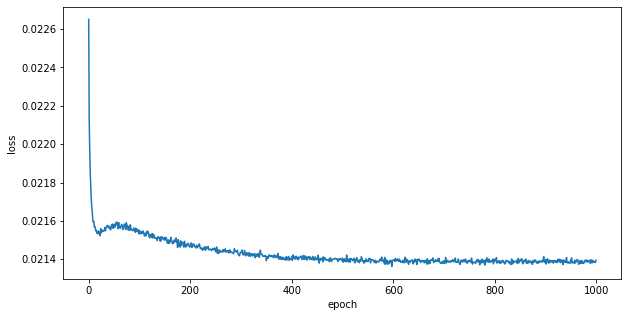

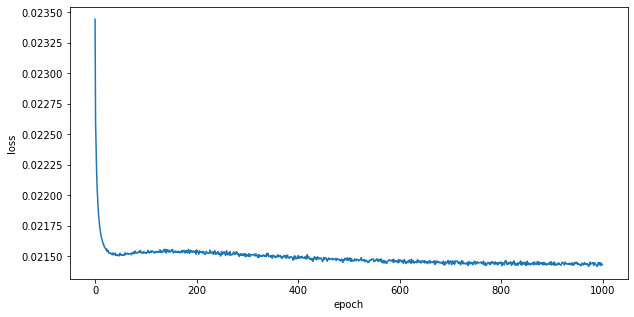

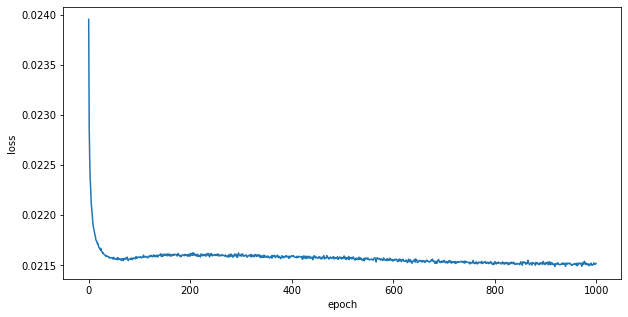

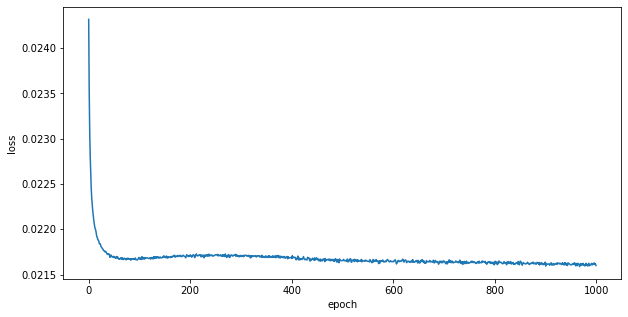

In [7]:
# plot
for emb_size in emb_size_list :
    for encoder_size in encoder_size_list :
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(loss_history_dict[f'(encoder_size : {encoder_size}, emb_size : {emb_size})'])
        ax.set_xlabel("epoch")
        ax.set_ylabel("loss")
        plt.plot()

        plt.savefig(f"figures/loss_{emb_size}emb_{encoder_size}enc_1000epochs.png")

# Pre-training with different architecture

In [5]:
corruption_rate = 0.5
dropout = 0.1
batch_size = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_loader = DataLoader(x_unlabel, batch_size=batch_size, shuffle=True)

# build model
model = SCARF_modified(
    input_dim=x_unlabel.shape[1],
    emb_dim=64, # 16 by default, augment in the future
    features_low=x_unlabel.min(axis=0),
    features_high=x_unlabel.max(axis=0),
    nb_classes=len(np.unique(train_dataset[:,0])),
    corruption_rate=corruption_rate,
    dropout=dropout
).to(device)

cuda


In [ ]:
# Training
import time
epochs = 1000

optimizer = Adam(model.parameters(), lr = 1e-3, weight_decay=1e-4)
ntxent_loss = NTXent()

loss_history = []

start = time.time()
for epoch in range(1, epochs+1) :
    epoch_loss = train_epoch(model, ntxent_loss, train_loader, optimizer, device)
    loss_history.append(epoch_loss)
    
    if epoch % 10 == 0 :
        print(f'Epoch {epoch}/{epochs} : loss = {loss_history[-1]}')
        # save model as .pt
        torch.save(model.state_dict(), 'saved_models/scarf_encoder_modified_statedict_1000epochs.pt')

end = time.time()
print(end-start)

Epoch 10/1000 : loss = 0.021642014509111195
Epoch 20/1000 : loss = 0.021555979882863636
Epoch 30/1000 : loss = 0.021557563314921188
Epoch 40/1000 : loss = 0.021558680388318725
Epoch 50/1000 : loss = 0.02157943514968124
Epoch 60/1000 : loss = 0.021531307865934473
Epoch 70/1000 : loss = 0.021482197306113917
Epoch 80/1000 : loss = 0.021430915470487418
Epoch 90/1000 : loss = 0.021375549705682458
Epoch 110/1000 : loss = 0.021308177350199724
Epoch 120/1000 : loss = 0.02128022936179307
Epoch 130/1000 : loss = 0.021277564548722434
Epoch 140/1000 : loss = 0.021268291994693957
Epoch 150/1000 : loss = 0.021261375727455067
Epoch 160/1000 : loss = 0.02125160020551353
Epoch 170/1000 : loss = 0.02125673008528307
Epoch 180/1000 : loss = 0.021243988493447972
Epoch 190/1000 : loss = 0.02124271869593933
Epoch 200/1000 : loss = 0.021227511055046114
Epoch 210/1000 : loss = 0.021223091486472542
Epoch 220/1000 : loss = 0.021223512198174824
Epoch 230/1000 : loss = 0.021224420160042883
Epoch 240/1000 : loss = 

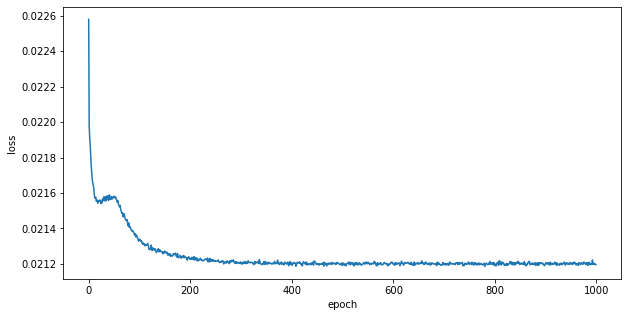

In [10]:
# plot 
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
plt.plot()

plt.savefig("loss_newarchi_1000epochs.png")

# Fine-tuning

## Fine-tuning without frozen layers

In [ ]:
### Load Data ###
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = read_process_data_TCGA("../data/TCGA/nopretrain_data.parquet", label_path="../data/TCGA/label.parquet")
idx = generate_indices(dataset, val_prop = 0.10, test_prop = 0.5, rs=42)
#idx = generate_indices(dataset)
cancer_dataset = CancerDatasetTCGA(dataset[:, 1:], dataset[:, 0], device)
dataloaders = get_dataloaders(cancer_dataset, idx, [256, 256, 256])
input_dim = dataloaders[0].dataset.inputs.shape[1] 
output_dim = dataloaders[0].dataset.labels.unique().shape[0]
#w = compute_loss_weights(dataset, device)

In [ ]:
corruption_rate = 0.5
dropout = 0.1
batch_size = 256
nb_classes = len(np.unique(dataset[:,0]))

print(device)

model = SCARF(
    input_dim=x_unlabel.shape[1],
    emb_dim=1024, # 16 by default, augment in the future
    features_low=x_unlabel.min(axis=0),
    features_high=x_unlabel.max(axis=0),
    nb_classes=nb_classes,
    num_hidden=4,
    corruption_rate=corruption_rate,
    dropout=dropout
).to(device)

model.load_state_dict(torch.load("saved_models/scarf_encoder_1024emb_4hid_statedict_1000epochs.pt"), strict=False)

In [10]:
name = "scarf_finetuning_nofrozen"
logger = LogResults(name, ["prop"])
bs = 16
prop_list = np.arange(0.02, 1.0, 0.01)

for i in range(5) : 
    for prop in prop_list :
        # logger
        logger.update_hyps([prop])

        idx = generate_indices(dataset, prop=prop, val_prop=0.1, test_prop=0.5, rs=42)
        
        dataloaders = get_dataloaders(cancer_dataset, idx, [8, 8, 8]) #[bs, bs, bs]

        ###
        #for batch in train_emb_loader :
            #print(len(batch))
        ###

        # build MLP
        config_nn = {
            "epochs":100,
            "lr_init":4e-4,
            "early_stop":5,
            "optim":optim.Adam,
            "bn":True,
            "dropout_rate":0.0
        }

        model = SCARF(
            input_dim=x_unlabel.shape[1],
            emb_dim=1024, # 16 by default, augment in the future
            features_low=x_unlabel.min(axis=0),
            features_high=x_unlabel.max(axis=0),
            nb_classes=nb_classes,
            corruption_rate=corruption_rate,
            dropout=dropout
        ).to(device)
        model.load_state_dict(torch.load("saved_models/scarf_encoder_1024_statedict_1000epochs.pt"), strict=False)

        #NN = Net(input_dim=x_train.shape[1], output_dim=len(np.unique(train_dataset[:,0])), dropout_rate=0.0).to(device)

        train_nn(config_nn, dataloaders, model, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger, test=True)
        logger.next_run()
        logger.show_progression()

    logger.save_csv()

18
2068 elements in the dataset
18 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 1, below are the last 5 epochs :
       id  epoch  val_acc  val_loss  test_acc  test_loss  \
29  run-0     29    0.540  2.226968  0.539729   2.183558   
30  run-0     30    0.545  2.198654  0.549419   2.144824   
31  run-0     31    0.535  2.143558  0.552326   2.083818   
32  run-0     32    0.535  2.058194  0.558140   2.023869   
33  run-0     33    0.540  2.063152  0.551357   2.015172   

                              optim    bn  dropout_rate  prop  
29  <class 'torch.optim.adam.Adam'>  True           0.0  0.02  
30  <class 'torch.optim.adam.Adam'>  True           0.0  0.02  
31  <class 'torch.optim.adam.Adam'>  True           0.0  0.02  
32  <class 'torch.optim.adam.Adam'>  True           0.0  0.02  
33  <class 'torch.optim.adam.Adam'>  True           0.0  0.02  
23
2068 elements in the dataset
23 elements in the trainset
207 elements in the valset
1034 ele

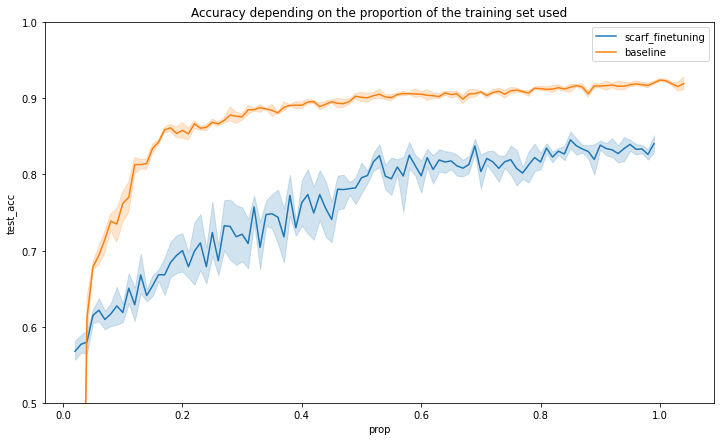

In [5]:
# Plot 
import seaborn as sns

df_results = pd.read_csv("scarf_finetuning_nofrozen.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
df_results = pd.read_csv('nn_baseline_validation.csv')
df_le_nn = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
plt.figure(figsize=(12, 7))
sns.lineplot(data=df_le, x="prop", y="test_acc", label='scarf_finetuning')
sns.lineplot(data=df_le_nn, x="prop", y="test_acc", label='baseline')
plt.title("Accuracy depending on the proportion of the training set used")
plt.ylim([0.5, 1])
plt.savefig('scarf_finetuning_nofrozen.png')

## Fine-tuning with frozen encoder

In [7]:
corruption_rate = 0.5
dropout = 0.1
batch_size = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
nb_classes = len(np.unique(dataset[:,0]))

# build models
model = SCARF(
    input_dim=x_unlabel.shape[1],
    emb_dim=1024, # 16 by default, augment in the future
    features_low=x_unlabel.min(axis=0),
    features_high=x_unlabel.max(axis=0),
    nb_classes=nb_classes,
    corruption_rate=corruption_rate,
    dropout=dropout
).to(device)

model.load_state_dict(torch.load("saved_models/scarf_encoder_1024_statedict_1000epochs.pt"), strict=False)

cuda


_IncompatibleKeys(missing_keys=['head.fc1.weight', 'head.fc1.bias', 'head.fc1_bn.weight', 'head.fc1_bn.bias', 'head.fc1_bn.running_mean', 'head.fc1_bn.running_var', 'head.fc2.weight', 'head.fc2.bias', 'head.fc2_bn.weight', 'head.fc2_bn.bias', 'head.fc2_bn.running_mean', 'head.fc2_bn.running_var', 'head.fc3.weight', 'head.fc3.bias', 'head.fc3_bn.weight', 'head.fc3_bn.bias', 'head.fc3_bn.running_mean', 'head.fc3_bn.running_var', 'head.fc4.weight', 'head.fc4.bias', 'head.fc4_bn.weight', 'head.fc4_bn.bias', 'head.fc4_bn.running_mean', 'head.fc4_bn.running_var', 'head.fc5.weight', 'head.fc5.bias'], unexpected_keys=['head.0.weight', 'head.0.bias', 'head.1.weight', 'head.1.bias', 'head.1.running_mean', 'head.1.running_var', 'head.1.num_batches_tracked', 'head.4.weight', 'head.4.bias', 'head.5.weight', 'head.5.bias', 'head.5.running_mean', 'head.5.running_var', 'head.5.num_batches_tracked', 'head.8.weight', 'head.8.bias', 'head.9.weight', 'head.9.bias', 'head.9.running_mean', 'head.9.running_v

In [10]:
from sklearn.preprocessing import StandardScaler
loader = DataLoader(dataset[:,1:], batch_size=8, shuffle=False)
embeddings = []

for x in loader:
    x = x.to(device)
    embeddings.append(x)
    #embeddings = tuple(embeddings)
embeddings = torch.cat(embeddings, 0).cpu().numpy()

embeddings


array([[ 9.155449  , -0.04178456,  0.10592928, ..., -0.46201226,
        -0.4422349 , -0.10277236],
       [-0.47072977, -0.06182518, -1.4200016 , ..., -1.1533126 ,
        -0.7433215 , -0.22409461],
       [ 1.226317  , -0.06268745, -0.5518269 , ..., -0.87564534,
        -0.49536785, -0.08467294],
       ...,
       [ 0.2397451 , -0.061008  , -0.37643594, ..., -0.29250085,
         0.859522  , -0.4330857 ],
       [ 0.19451827, -0.05727715, -0.41886315, ..., -0.7005429 ,
        -0.3448245 ,  0.7951257 ],
       [ 0.6227987 , -0.05079044,  0.39849612, ..., -0.64145255,
         1.2314526 , -0.2667978 ]], dtype=float32)

In [12]:
np.array_equal(dataset[:,1:], embeddings)

True

In [32]:
name = "scarf_finetuning_frozenencoder"
logger = LogResults(name, ["prop"])
bs = 16
prop_list = np.arange(0.02, 1.0, 0.01)

for i in range(5) :
    for prop in prop_list :
        # logger
        logger.update_hyps([prop])

        # split training set depending on prop value
        idx = generate_indices(dataset, prop=prop, val_prop=0.1, test_prop=0.5, rs=42)

        # get embeddings
        loader = DataLoader(dataset[:,1:], batch_size=bs, shuffle=False)
        embeddings = dataset_embeddings(encoder, loader, device)
        #train_embeddings = dataset_embeddings(encoder, train_loader, device)
        #val_embeddings = dataset_embeddings(encoder, val_loader, device)
        #test_embeddings = dataset_embeddings(encoder, test_loader, device)
        
        embeddings = []
        from tqdm.auto import tqdm
        for batch in tqdm(loader) : 
            batch = batch.to(device)
            embeddings.append(encoder.get_embeddings(batch))
        embeddings = torch.cat(embeddings, 0).cpu().numpy()
        

        # split 
        embeddings_dataset = CancerDatasetTCGA(embeddings, dataset[:,0], device)
        dataloaders = get_dataloaders(embeddings_dataset, idx, [bs, bs, bs])
        #dataloaders = get_dataloaders(cancer_dataset, idx, [bs, bs, bs])

        # Embeddings DataSets
        #train_embeddings_ds = CancerDatasetTCGA(train_embeddings, y_train_tmp, device)
        #val_embeddings_ds = CancerDatasetTCGA(val_embeddings, y_val_tmp, device)
        #test_embeddings_ds = CancerDatasetTCGA(test_embeddings, y_test, device)

        # Embeddings DataLoader
        #train_emb_loader = DataLoader(train_embeddings_ds, batch_size=bs, shuffle=False, drop_last=True)
        #val_emb_loader = DataLoader(val_embeddings_ds, batch_size=bs, shuffle=False, drop_last=True)
        #test_emb_loader = DataLoader(test_embeddings_ds, batch_size=bs, shuffle=False, drop_last=True)
        #dataloaders = [train_emb_loader, val_emb_loader, test_emb_loader]

        ###
        #for batch in train_emb_loader :
            #print(len(batch))
        ###

        # build MLP
        config_nn = {
            "epochs":100,
            "lr_init":4e-4,
            "early_stop":5,
            "optim":optim.Adam,
            "bn":True,
            "dropout_rate":0.0
        }

        NN = MLP(input_dim=embeddings.shape[1], hidden_dim=nb_classes, num_hidden=2, dropout=0.0).to(device)
        train_nn(config_nn, dataloaders, NN, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger, test=True, mlp_only=True)
        logger.next_run()
        logger.show_progression()

    logger.save_csv()

18


  0%|          | 0/130 [00:00<?, ?it/s]

2068 elements in the dataset
18 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 1, below are the last 5 epochs :
       id  epoch   val_acc  val_loss  test_acc  test_loss  \
10  run-0     10  0.057292  2.945097  0.064453   2.949401   
11  run-0     11  0.052083  2.939870  0.070312   2.950262   
12  run-0     12  0.057292  2.940691  0.070312   2.949676   
13  run-0     13  0.041667  2.940560  0.067383   2.949419   
14  run-0     14  0.052083  2.946311  0.064453   2.950179   

                              optim    bn  dropout_rate  prop  
10  <class 'torch.optim.adam.Adam'>  True           0.0  0.02  
11  <class 'torch.optim.adam.Adam'>  True           0.0  0.02  
12  <class 'torch.optim.adam.Adam'>  True           0.0  0.02  
13  <class 'torch.optim.adam.Adam'>  True           0.0  0.02  
14  <class 'torch.optim.adam.Adam'>  True           0.0  0.02  
23


  0%|          | 0/130 [00:00<?, ?it/s]

2068 elements in the dataset
23 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 2, below are the last 5 epochs :
       id  epoch   val_acc  val_loss  test_acc  test_loss  \
22  run-1      7  0.036458  2.936460  0.059570   2.941563   
23  run-1      8  0.036458  2.937080  0.068359   2.942092   
24  run-1      9  0.031250  2.933328  0.050781   2.941512   
25  run-1     10  0.046875  2.933634  0.062500   2.942462   
26  run-1     11  0.041667  2.934313  0.058594   2.941408   

                              optim    bn  dropout_rate  prop  
22  <class 'torch.optim.adam.Adam'>  True           0.0  0.03  
23  <class 'torch.optim.adam.Adam'>  True           0.0  0.03  
24  <class 'torch.optim.adam.Adam'>  True           0.0  0.03  
25  <class 'torch.optim.adam.Adam'>  True           0.0  0.03  
26  <class 'torch.optim.adam.Adam'>  True           0.0  0.03  
35


  0%|          | 0/130 [00:00<?, ?it/s]

2068 elements in the dataset
35 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 3, below are the last 5 epochs :
       id  epoch   val_acc  val_loss  test_acc  test_loss  \
38  run-2     11  0.062500  2.965295  0.041992   2.949432   
39  run-2     12  0.052083  2.965723  0.041992   2.950082   
40  run-2     13  0.057292  2.960719  0.041992   2.949850   
41  run-2     14  0.041667  2.961789  0.050781   2.950847   
42  run-2     15  0.052083  2.972643  0.048828   2.950590   

                              optim    bn  dropout_rate  prop  
38  <class 'torch.optim.adam.Adam'>  True           0.0  0.04  
39  <class 'torch.optim.adam.Adam'>  True           0.0  0.04  
40  <class 'torch.optim.adam.Adam'>  True           0.0  0.04  
41  <class 'torch.optim.adam.Adam'>  True           0.0  0.04  
42  <class 'torch.optim.adam.Adam'>  True           0.0  0.04  
40


  0%|          | 0/130 [00:00<?, ?it/s]

2068 elements in the dataset
40 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 4, below are the last 5 epochs :
       id  epoch   val_acc  val_loss  test_acc  test_loss  \
55  run-3     12  0.057292  2.961295  0.058594   2.961097   
56  run-3     13  0.078125  2.960018  0.053711   2.961954   
57  run-3     14  0.067708  2.961589  0.053711   2.963038   
58  run-3     15  0.062500  2.959406  0.053711   2.965541   
59  run-3     16  0.052083  2.964108  0.050781   2.965701   

                              optim    bn  dropout_rate  prop  
55  <class 'torch.optim.adam.Adam'>  True           0.0  0.05  
56  <class 'torch.optim.adam.Adam'>  True           0.0  0.05  
57  <class 'torch.optim.adam.Adam'>  True           0.0  0.05  
58  <class 'torch.optim.adam.Adam'>  True           0.0  0.05  
59  <class 'torch.optim.adam.Adam'>  True           0.0  0.05  
51


  0%|          | 0/130 [00:00<?, ?it/s]

2068 elements in the dataset
51 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 5, below are the last 5 epochs :
       id  epoch   val_acc  val_loss  test_acc  test_loss  \
67  run-4      7  0.072917  2.972691  0.055664   2.949798   
68  run-4      8  0.067708  2.966044  0.061523   2.948805   
69  run-4      9  0.072917  2.965487  0.059570   2.948215   
70  run-4     10  0.078125  2.974979  0.064453   2.948505   
71  run-4     11  0.062500  2.976819  0.066406   2.948417   

                              optim    bn  dropout_rate  prop  
67  <class 'torch.optim.adam.Adam'>  True           0.0  0.06  
68  <class 'torch.optim.adam.Adam'>  True           0.0  0.06  
69  <class 'torch.optim.adam.Adam'>  True           0.0  0.06  
70  <class 'torch.optim.adam.Adam'>  True           0.0  0.06  
71  <class 'torch.optim.adam.Adam'>  True           0.0  0.06  
57


  0%|          | 0/130 [00:00<?, ?it/s]

2068 elements in the dataset
57 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 6, below are the last 5 epochs :
       id  epoch   val_acc  val_loss  test_acc  test_loss  \
83  run-5     11  0.067708  2.948971  0.067383   2.942391   
84  run-5     12  0.067708  2.947098  0.062500   2.943099   
85  run-5     13  0.062500  2.948441  0.066406   2.943601   
86  run-5     14  0.062500  2.955676  0.069336   2.944666   
87  run-5     15  0.067708  2.950752  0.066406   2.946791   

                              optim    bn  dropout_rate  prop  
83  <class 'torch.optim.adam.Adam'>  True           0.0  0.07  
84  <class 'torch.optim.adam.Adam'>  True           0.0  0.07  
85  <class 'torch.optim.adam.Adam'>  True           0.0  0.07  
86  <class 'torch.optim.adam.Adam'>  True           0.0  0.07  
87  <class 'torch.optim.adam.Adam'>  True           0.0  0.07  
67


  0%|          | 0/130 [00:00<?, ?it/s]

2068 elements in the dataset
67 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 7, below are the last 5 epochs :
        id  epoch   val_acc  val_loss  test_acc  test_loss  \
102  run-6     14  0.026042  2.973447  0.047852   2.955423   
103  run-6     15  0.020833  2.987884  0.044922   2.960635   
104  run-6     16  0.020833  2.983603  0.048828   2.969833   
105  run-6     17  0.026042  3.014792  0.053711   2.975669   
106  run-6     18  0.041667  2.996732  0.036133   2.984988   

                               optim    bn  dropout_rate  prop  
102  <class 'torch.optim.adam.Adam'>  True           0.0  0.08  
103  <class 'torch.optim.adam.Adam'>  True           0.0  0.08  
104  <class 'torch.optim.adam.Adam'>  True           0.0  0.08  
105  <class 'torch.optim.adam.Adam'>  True           0.0  0.08  
106  <class 'torch.optim.adam.Adam'>  True           0.0  0.08  
75


  0%|          | 0/130 [00:00<?, ?it/s]

2068 elements in the dataset
75 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 8, below are the last 5 epochs :
        id  epoch   val_acc  val_loss  test_acc  test_loss  \
118  run-7     11  0.052083  2.975267  0.070312   2.964908   
119  run-7     12  0.057292  2.979276  0.061523   2.967636   
120  run-7     13  0.046875  2.981744  0.067383   2.971187   
121  run-7     14  0.031250  2.995277  0.068359   2.977196   
122  run-7     15  0.031250  3.000414  0.060547   2.981766   

                               optim    bn  dropout_rate  prop  
118  <class 'torch.optim.adam.Adam'>  True           0.0  0.09  
119  <class 'torch.optim.adam.Adam'>  True           0.0  0.09  
120  <class 'torch.optim.adam.Adam'>  True           0.0  0.09  
121  <class 'torch.optim.adam.Adam'>  True           0.0  0.09  
122  <class 'torch.optim.adam.Adam'>  True           0.0  0.09  
80


  0%|          | 0/130 [00:00<?, ?it/s]

2068 elements in the dataset
80 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 9, below are the last 5 epochs :
        id  epoch   val_acc  val_loss  test_acc  test_loss  \
130  run-8      7  0.057292  2.939654  0.063477   2.939226   
131  run-8      8  0.057292  2.940752  0.066406   2.938167   
132  run-8      9  0.067708  2.942683  0.068359   2.939042   
133  run-8     10  0.067708  2.960697  0.069336   2.942451   
134  run-8     11  0.067708  2.961935  0.066406   2.948977   

                               optim    bn  dropout_rate  prop  
130  <class 'torch.optim.adam.Adam'>  True           0.0   0.1  
131  <class 'torch.optim.adam.Adam'>  True           0.0   0.1  
132  <class 'torch.optim.adam.Adam'>  True           0.0   0.1  
133  <class 'torch.optim.adam.Adam'>  True           0.0   0.1  
134  <class 'torch.optim.adam.Adam'>  True           0.0   0.1  
91


  0%|          | 0/130 [00:00<?, ?it/s]

2068 elements in the dataset
91 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 10, below are the last 5 epochs :
        id  epoch   val_acc  val_loss  test_acc  test_loss  \
146  run-9     11  0.067708  2.953028  0.058594   2.955849   
147  run-9     12  0.083333  2.958170  0.069336   2.964805   
148  run-9     13  0.067708  2.963636  0.066406   2.971723   
149  run-9     14  0.052083  2.987618  0.058594   2.982462   
150  run-9     15  0.062500  2.999357  0.062500   2.995388   

                               optim    bn  dropout_rate  prop  
146  <class 'torch.optim.adam.Adam'>  True           0.0  0.11  
147  <class 'torch.optim.adam.Adam'>  True           0.0  0.11  
148  <class 'torch.optim.adam.Adam'>  True           0.0  0.11  
149  <class 'torch.optim.adam.Adam'>  True           0.0  0.11  
150  <class 'torch.optim.adam.Adam'>  True           0.0  0.11  
99


  0%|          | 0/130 [00:00<?, ?it/s]

2068 elements in the dataset
99 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 11, below are the last 5 epochs :
         id  epoch   val_acc  val_loss  test_acc  test_loss  \
164  run-10     13  0.041667  2.964642  0.057617   2.986770   
165  run-10     14  0.062500  2.972354  0.056641   2.992378   
166  run-10     15  0.072917  2.978129  0.057617   2.991891   
167  run-10     16  0.062500  2.978416  0.068359   2.992723   
168  run-10     17  0.046875  2.970353  0.058594   2.995014   

                               optim    bn  dropout_rate  prop  
164  <class 'torch.optim.adam.Adam'>  True           0.0  0.12  
165  <class 'torch.optim.adam.Adam'>  True           0.0  0.12  
166  <class 'torch.optim.adam.Adam'>  True           0.0  0.12  
167  <class 'torch.optim.adam.Adam'>  True           0.0  0.12  
168  <class 'torch.optim.adam.Adam'>  True           0.0  0.12  
106


  0%|          | 0/130 [00:00<?, ?it/s]

2068 elements in the dataset
106 elements in the trainset
207 elements in the valset
1034 elements in the testset


KeyboardInterrupt: 

Text(0.5, 1.0, 'Accuracy depending on the proportion of the training set used')

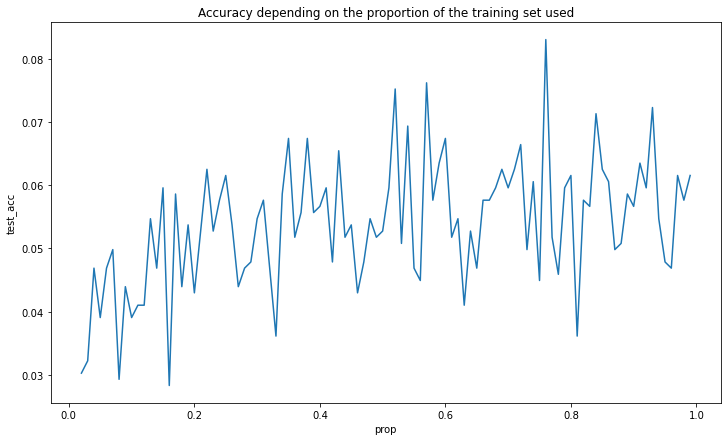

In [36]:
### Plot ###
import seaborn as sns

df_results = pd.read_csv("scarf_finetuning_frozenencoder.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
plt.figure(figsize=(12, 7))
sns.lineplot(data=df_le, x="prop", y="test_acc")
plt.title("Accuracy depending on the proportion of the training set used")
plt.savefig("scarf_finetuning_frozenencoder.png")

# Training whole model with random initialisation

In [5]:
### Load Data ###
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = read_process_data_TCGA("../nn_baseline/data/nopretrain_data.parquet", label_path="../data/TCGA/label.parquet")
idx = generate_indices(dataset, val_prop = 0.10, test_prop = 0.5, rs=42)
#idx = generate_indices(dataset)
cancer_dataset = CancerDatasetTCGA(dataset[:, 1:], dataset[:, 0], device)
dataloaders = get_dataloaders(cancer_dataset, idx, [256, 256, 256])
input_dim = dataloaders[0].dataset.inputs.shape[1] 
output_dim = dataloaders[0].dataset.labels.unique().shape[0]
#w = compute_loss_weights(dataset, device)

Index(['cancer_type', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       ...
       'ENSG00000288658', 'ENSG00000288659', 'ENSG00000288660',
       'ENSG00000288662', 'ENSG00000288663', 'ENSG00000288667',
       'ENSG00000288669', 'ENSG00000288670', 'ENSG00000288674',
       'ENSG00000288675'],
      dtype='object', length=56903)
2068 elements in the dataset
827 elements in the trainset
207 elements in the valset
1034 elements in the testset


In [6]:
corruption_rate = 0.5
dropout = 0.1
batch_size = 256
nb_classes = len(np.unique(dataset[:,0]))

print(device)

model = SCARF(
    input_dim=x_unlabel.shape[1],
    emb_dim=1024, # 16 by default, augment in the future
    features_low=x_unlabel.min(axis=0),
    features_high=x_unlabel.max(axis=0),
    nb_classes=nb_classes,
    corruption_rate=corruption_rate,
    dropout=dropout
).to(device)

cuda


In [15]:
len(np.arange(0.05, 1.05, 0.05))

20

In [ ]:
names = ["scarf_randominit_simpleMLP", "scarf_finetuninginit_simpleMLP"]
bs = 8
prop_list = np.arange(0.05, 1.05, 0.05)
#prop_list = [1]

for name, entire in zip(names, [True, False]) :
    logger = LogResults(name, ["prop"])
    for i in range(5) : 
        for prop in prop_list :
            # logger
            logger.update_hyps([prop])

            idx = generate_indices(dataset, prop=prop, val_prop=0.1, test_prop=0.5, rs=42)

            dataloaders = get_dataloaders(cancer_dataset, idx, [bs, 32, 32]) #[bs, bs, bs]

            ###
            #for batch in train_emb_loader :
                #print(len(batch))
            ###

            # build MLP
            config_nn = {
                "epochs":100,
                "lr_init":4e-4,
                "early_stop":50,
                "optim":optim.Adam,
                "bn":True,
                "dropout_rate":0.0
            }

            model = SCARF(
                input_dim=x_unlabel.shape[1],
                emb_dim=1024, # 16 by default, augment in the future
                features_low=x_unlabel.min(axis=0),
                features_high=x_unlabel.max(axis=0),
                nb_classes=nb_classes,
                corruption_rate=corruption_rate,
                dropout=dropout
            ).to(device)
            
            if not entire : model.load_state_dict(torch.load("saved_models/scarf_encoder_1024_statedict_1000epochs.pt"), strict=False)

            #NN = Net(input_dim=x_train.shape[1], output_dim=len(np.unique(train_dataset[:,0])), dropout_rate=0.0).to(device)
            
            train_nn(config_nn, dataloaders, model, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger, test=True)
            logger.next_run()
            logger.show_progression()

        logger.save_csv()

40
2068 elements in the dataset
40 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 1, below are the last 5 epochs :
       id  epoch   val_acc  val_loss  test_acc  test_loss  \
95  run-0     95  0.661458  2.668527  0.709961   2.540524   
96  run-0     96  0.645833  2.685031  0.714844   2.580523   
97  run-0     97  0.666667  2.667764  0.707031   2.556692   
98  run-0     98  0.656250  2.633805  0.705078   2.523997   
99  run-0     99  0.666667  2.715103  0.706055   2.623850   

                              optim    bn  dropout_rate  prop  
95  <class 'torch.optim.adam.Adam'>  True           0.0  0.05  
96  <class 'torch.optim.adam.Adam'>  True           0.0  0.05  
97  <class 'torch.optim.adam.Adam'>  True           0.0  0.05  
98  <class 'torch.optim.adam.Adam'>  True           0.0  0.05  
99  <class 'torch.optim.adam.Adam'>  True           0.0  0.05  
82
2068 elements in the dataset
82 elements in the trainset
207 elements in the valset
10

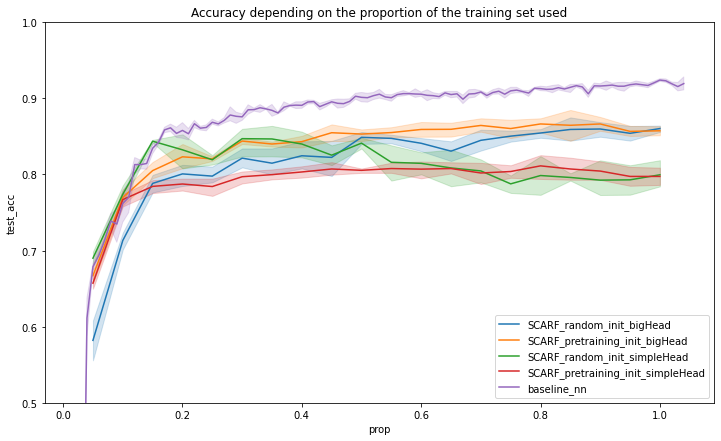

In [31]:
# BoxPlot
import seaborn as sns

df_results = pd.read_csv("scarf_randominit.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
df_results = pd.read_csv("scarf_finetuninginit.csv")
df_le2 = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
df_results = pd.read_csv("scarf_randominit_simpleMLP.csv")
df_le_simple = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
df_results = pd.read_csv("scarf_finetuninginit_simpleMLP.csv")
df_le2_simple = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
df_results = pd.read_csv('nn_baseline_validation.csv')
df_le_nn = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
plt.figure(figsize=(12, 7))
sns.lineplot(data=df_le, x="prop", y="test_acc", label='SCARF_random_init_bigHead')
sns.lineplot(data=df_le2, x="prop", y="test_acc", label="SCARF_pretraining_init_bigHead")
sns.lineplot(data=df_le_simple, x="prop", y="test_acc", label='SCARF_random_init_simpleHead')
sns.lineplot(data=df_le2_simple, x="prop", y="test_acc", label="SCARF_pretraining_init_simpleHead")
sns.lineplot(data=df_le_nn, x="prop", y="test_acc", label="baseline_nn")
plt.title("Accuracy depending on the proportion of the training set used")
plt.ylim([0.5, 1.0])
#plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='lower right')
plt.savefig("scarf_finetuning_frozenencoder.png")

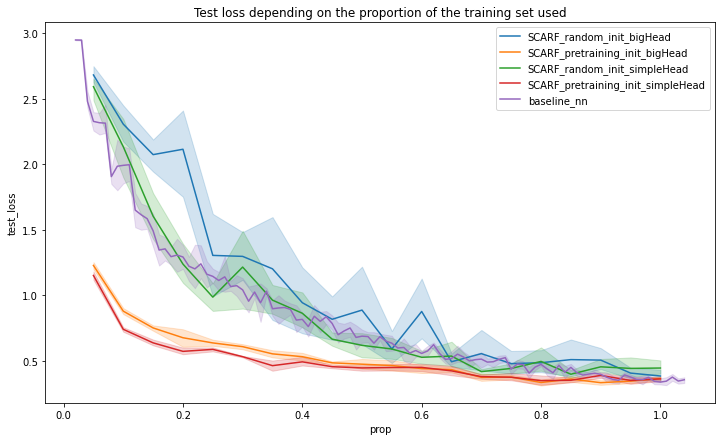

In [35]:
# BoxPlot
import seaborn as sns

df_results = pd.read_csv("scarf_randominit.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
df_results = pd.read_csv("scarf_finetuninginit.csv")
df_le2 = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
df_results = pd.read_csv("scarf_randominit_simpleMLP.csv")
df_le_simple = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
df_results = pd.read_csv("scarf_finetuninginit_simpleMLP.csv")
df_le2_simple = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
df_results = pd.read_csv('nn_baseline_validation.csv')
df_le_nn = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
plt.figure(figsize=(12, 7))
sns.lineplot(data=df_le, x="prop", y="test_loss", label='SCARF_random_init_bigHead')
sns.lineplot(data=df_le2, x="prop", y="test_loss", label="SCARF_pretraining_init_bigHead")
sns.lineplot(data=df_le_simple, x="prop", y="test_loss", label='SCARF_random_init_simpleHead')
sns.lineplot(data=df_le2_simple, x="prop", y="test_loss", label="SCARF_pretraining_init_simpleHead")
sns.lineplot(data=df_le_nn, x="prop", y="test_loss", label="baseline_nn")
plt.title("Test loss depending on the proportion of the training set used")
#plt.ylim([0.5, 1.0])
#plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper right')
plt.savefig("scarf_finetuning_frozenencoder.png")

# Changing Encoder size

# Compare models with different Encoder size and Embeddings dimension

In [10]:
corruption_rate = 0.5
dropout = 0.1
batch_size = 256
nb_classes = len(np.unique(dataset[:,0]))

In [12]:
name = "training_csv/scarf_encoderSize_embSize1024_comp"
bs = 32
encoder_size_list = [4, 5, 6, 7, 8, 9, 10]
#emb_size_list = [1024, 512, 256, 128, 64]
emb_size_list = [1024]
prop_list = [1]
logger = LogResults(name, ["encoder_size", "emb_size"])

for encoder_size in encoder_size_list :
    for emb_size in emb_size_list : 
        for i in range(5) :
            # logger
            logger.update_hyps([encoder_size, emb_size])

            idx = generate_indices(dataset, prop=1, val_prop=0.1, test_prop=0.5, rs=42)

            dataloaders = get_dataloaders(cancer_dataset, idx, [bs, 32, 32]) #[bs, bs, bs]

            ###
            #for batch in train_emb_loader :
                #print(len(batch))
            ###

            # build MLP
            config_nn = {
                "epochs":100,
                "lr_init":4e-4,
                "early_stop":50,
                "optim":optim.Adam,
                "bn":True,
                "dropout_rate":0.0
            }

            model = SCARF(
                input_dim=x_unlabel.shape[1],
                emb_dim=emb_size, # 16 by default, augment in the future
                features_low=x_unlabel.min(axis=0),
                features_high=x_unlabel.max(axis=0),
                nb_classes=nb_classes,
                num_hidden=encoder_size,
                corruption_rate=corruption_rate,
                dropout=dropout
            ).to(device)
            
            model.load_state_dict(torch.load(f"saved_models/scarf_encoder_1024emb_{encoder_size}enc_statedict_1000epochs.pt"), strict=False)

            #NN = Net(input_dim=x_train.shape[1], output_dim=len(np.unique(train_dataset[:,0])), dropout_rate=0.0).to(device)
            
            train_nn(config_nn, dataloaders, model, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger, test=True)
            logger.next_run()
            logger.show_progression()

        logger.save_csv()

2068 elements in the dataset
827 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 1, below are the last 5 epochs :
       id  epoch   val_acc  val_loss  test_acc  test_loss  \
74  run-0     74  0.880208  0.314087  0.900391   0.362023   
75  run-0     75  0.864583  0.333358  0.909180   0.383569   
76  run-0     76  0.875000  0.421126  0.899414   0.356451   
77  run-0     77  0.869792  0.437380  0.904297   0.439381   
78  run-0     78  0.869792  0.391660  0.890625   0.386475   

                              optim    bn  dropout_rate  encoder_size  \
74  <class 'torch.optim.adam.Adam'>  True           0.0             4   
75  <class 'torch.optim.adam.Adam'>  True           0.0             4   
76  <class 'torch.optim.adam.Adam'>  True           0.0             4   
77  <class 'torch.optim.adam.Adam'>  True           0.0             4   
78  <class 'torch.optim.adam.Adam'>  True           0.0             4   

    emb_size  
74      1024  
75    

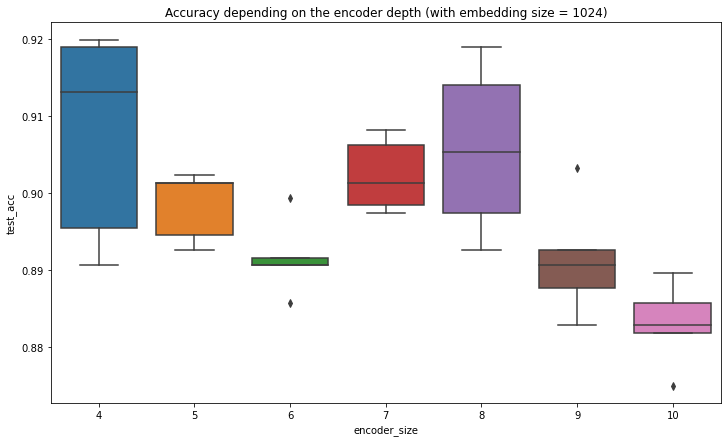

In [17]:
### Plot ###
import seaborn as sns

df_results = pd.read_csv("training_csv/scarf_encoderSize_embSize1024_comp.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
plt.figure(figsize=(12, 7))
sns.boxplot(x=df_le["encoder_size"], y=df_le["test_acc"])
plt.title("Accuracy depending on the encoder depth (with embedding size = 1024)")
plt.savefig("figures/1024emb_encSize_comp.png")

# Changing Embeddings dimension

In [15]:
name = "training_csv/scarf_encoderSize4_embSize_comp"
bs = 32
encoder_size_list = [4]
#emb_size_list = [1024, 512, 256, 128, 64]
emb_size_list = [1024, 512, 128, 64, 32]
prop_list = [1]
logger = LogResults(name, ["encoder_size", "emb_size"])

for encoder_size in encoder_size_list :
    for emb_size in emb_size_list : 
        for i in range(5) :
            # logger
            logger.update_hyps([encoder_size, emb_size])

            idx = generate_indices(dataset, prop=1, val_prop=0.1, test_prop=0.5, rs=42)

            dataloaders = get_dataloaders(cancer_dataset, idx, [bs, 32, 32]) #[bs, bs, bs]

            ###
            #for batch in train_emb_loader :
                #print(len(batch))
            ###

            # build MLP
            config_nn = {
                "epochs":100,
                "lr_init":4e-4,
                "early_stop":50,
                "optim":optim.Adam,
                "bn":True,
                "dropout_rate":0.0
            }

            model = SCARF(
                input_dim=x_unlabel.shape[1],
                emb_dim=emb_size, # 16 by default, augment in the future
                features_low=x_unlabel.min(axis=0),
                features_high=x_unlabel.max(axis=0),
                nb_classes=nb_classes,
                num_hidden=encoder_size,
                corruption_rate=corruption_rate,
                dropout=dropout
            ).to(device)
            
            model.load_state_dict(torch.load(f"saved_models/scarf_encoder_{emb_size}emb_4enc_statedict_1000epochs.pt"), strict=False)

            #NN = Net(input_dim=x_train.shape[1], output_dim=len(np.unique(train_dataset[:,0])), dropout_rate=0.0).to(device)
            
            train_nn(config_nn, dataloaders, model, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger, test=True)
            logger.next_run()
            logger.show_progression()

        logger.save_csv()

2068 elements in the dataset
827 elements in the trainset
207 elements in the valset
1034 elements in the testset

Iteration 1, below are the last 5 epochs :
       id  epoch   val_acc  val_loss  test_acc  test_loss  \
82  run-0     82  0.895833  0.427473  0.905273   0.408367   
83  run-0     83  0.880208  0.390129  0.895508   0.407050   
84  run-0     84  0.880208  0.386055  0.893555   0.393799   
85  run-0     85  0.880208  0.282392  0.901367   0.421754   
86  run-0     86  0.895833  0.358929  0.906250   0.410190   

                              optim    bn  dropout_rate  encoder_size  \
82  <class 'torch.optim.adam.Adam'>  True           0.0             4   
83  <class 'torch.optim.adam.Adam'>  True           0.0             4   
84  <class 'torch.optim.adam.Adam'>  True           0.0             4   
85  <class 'torch.optim.adam.Adam'>  True           0.0             4   
86  <class 'torch.optim.adam.Adam'>  True           0.0             4   

    emb_size  
82      1024  
83    

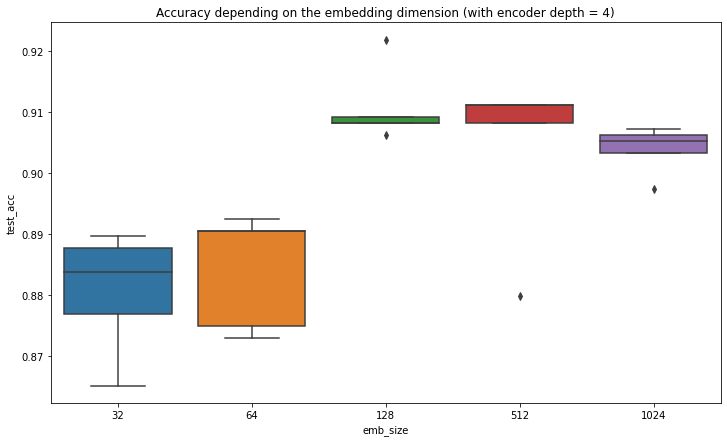

In [17]:
### Plot ###
import seaborn as sns

df_results = pd.read_csv("training_csv/scarf_encoderSize4_embSize_comp.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
plt.figure(figsize=(12, 7))
sns.boxplot(x=df_le["emb_size"], y=df_le["test_acc"])
plt.title("Accuracy depending on the embedding dimension (with encoder depth = 4)")
plt.savefig("figures/scarf_encoderSize4_embSize_comp.png")

# Finetune with logistic regression

## Baseline

In [9]:
name = 'LogReg_baseline.csv'
history = pd.DataFrame(columns=['train_acc', 'test_acc', 'prop'])

prop_list = np.arange(0.02, 1.01, 0.01)

for prop in prop_list :
    idx = generate_indices(dataset, prop=prop, val_prop=0.1, test_prop=0.5, rs=42)
    data, label = dataset[:,1:], dataset[:,0]
    x_train_tmp, y_train_tmp = data[idx[0]], label[idx[0]]
    x_test_tmp, y_test_tmp = data[idx[2]], label[idx[2]]
    
    clf = LogisticRegression()
    
    # Train
    clf.fit(x_train_tmp, y_train_tmp)
    # Test
    #train_pred = clf.predict(x_train_tmp)
    #test_pred = clf.predict(x_test_tmp)
    #print(x_train_tmp.shape, y_train_tmp.shape, train_pred.shape)
    train_acc, test_acc = clf.score(x_train_tmp, y_train_tmp), clf.score(x_test_tmp, y_test_tmp)
    
    history.loc[len(history)] = [train_acc, test_acc, prop]
history.to_csv(name)    

18
23
35
40
51
57
67
75


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


80
91
99
106


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


117
122


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


134


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


140


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


149


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


157
165
173
181
192


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


199


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


205
214


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


222


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


232


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


240


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


249


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


257


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


262


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


276


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


282


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


289


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


297


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


307


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


316


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


321


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


334


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


337


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


348


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


355


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


363


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


372


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


380


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


389


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


398


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


407


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


408


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


420


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


429


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


438


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


447


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


455
464


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


472


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


479


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


490


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


493


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


506


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


511


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


520


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


530


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


538


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


545


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


551


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


565


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


570


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


576


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


587


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


595


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


605


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


613


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


617


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


628


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


635


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


646


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


654


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


662


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


670


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


678


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


687


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


693


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


705


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


710


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


721


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


728


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


736


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


744


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


752


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


760


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


770


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


776


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


787


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


792


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


804


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


809


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


824


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


827


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


(0.6, 1.0)

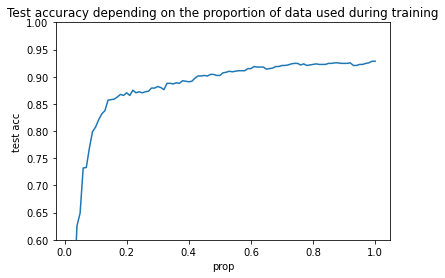

In [11]:
plt.figure()
plt.plot(np.arange(0.02, 1.01, 0.01), np.array(history['test_acc']))
plt.xlabel('prop')
plt.ylabel('test acc')
plt.title('Test accuracy depending on the proportion of data used during training')
plt.ylim([0.6, 1])

In [19]:
clf = LogisticRegression()

# DataLoaders
train_loader = DataLoader(x_train, batch_size=bs, shuffle=False, drop_last=False)
#val_loader = DataLoader(x_val_tmp, batch_size=bs, shuffle=True, drop_last=True)
test_loader = DataLoader(x_test, batch_size=bs, shuffle=False, drop_last=False)

# get embeddings
train_embeddings = dataset_embeddings(encoder, train_loader, device)
#val_embeddings = dataset_embeddings(encoder, val_loader, device)
test_embeddings = dataset_embeddings(encoder, test_loader, device)

NameError: name 'encoder' is not defined

In [30]:
clf.fit(train_embeddings, y_train)


LogisticRegression()

In [31]:
predictions = clf.predict(test_embeddings)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.21      0.60      0.31        72
         1.0       0.00      0.00      0.00        47
         2.0       0.13      0.80      0.23       126
         3.0       0.00      0.00      0.00        32
         4.0       0.22      0.04      0.07        51
         5.0       0.00      0.00      0.00        58
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        29
         8.0       0.00      0.00      0.00        64
         9.0       0.00      0.00      0.00        44
        10.0       0.00      0.00      0.00        48
        11.0       0.00      0.00      0.00        47
        12.0       0.00      0.00      0.00        41
        13.0       0.00      0.00      0.00        61
        14.0       0.00      0.00      0.00        25
        15.0       0.00      0.00      0.00        64
        16.0       0.00      0.00      0.00        50
        17.0       0.00    

/home/kdradjat/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kdradjat/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kdradjat/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Train with original data

In [32]:
clf = LogisticRegression()

# DataLoaders
train_loader = DataLoader(x_train, batch_size=bs, shuffle=True, drop_last=False)
test_loader = DataLoader(x_test, batch_size=bs, shuffle=True, drop_last=False)

In [33]:
clf.fit(x_train, y_train)

LogisticRegression()

In [34]:
predictions_raw = clf.predict(x_test)
print(classification_report(y_test, predictions_raw))

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90        72
         1.0       0.98      0.91      0.95        47
         2.0       0.99      0.96      0.98       126
         3.0       0.90      0.81      0.85        32
         4.0       0.98      0.98      0.98        51
         5.0       0.95      0.90      0.92        58
         6.0       0.96      0.93      0.95        58
         7.0       0.89      0.86      0.88        29
         8.0       0.98      1.00      0.99        64
         9.0       1.00      0.98      0.99        44
        10.0       0.86      0.92      0.89        48
        11.0       0.84      0.91      0.88        47
        12.0       0.91      1.00      0.95        41
        13.0       0.97      0.93      0.95        61
        14.0       0.86      1.00      0.93        25
        15.0       1.00      0.98      0.99        64
        16.0       0.92      0.96      0.94        50
        17.0       1.00    

# tSNE of representations

No handles with labels found to put in legend.


Text(0.5, 1.0, 'tSNE with raw data')

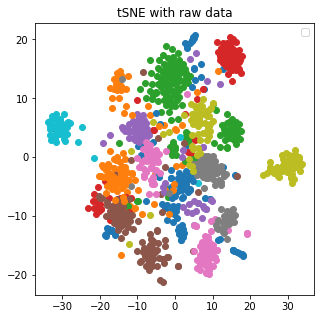

In [14]:
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(x_train)
positive_list = []
for i in range(len(np.unique(train_dataset[:,0]))) :
    positive_list.append(y_train == i)

fig, ax = plt.subplots(figsize=(5, 5))

for positive in positive_list :
    ax.scatter(reduced[positive, 0], reduced[positive, 1])
#ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()
plt.title("tSNE with raw data")

No handles with labels found to put in legend.


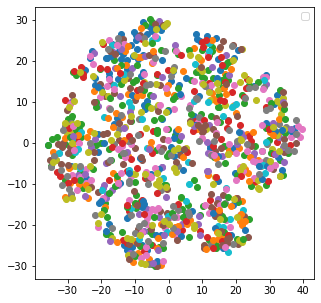

In [35]:
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(train_embeddings)
positive_list = []
for i in range(len(np.unique(train_dataset[:,0]))) :
    positive_list.append(y_train == i)

fig, ax = plt.subplots(figsize=(5, 5))

for positive in positive_list :
    ax.scatter(reduced[positive, 0], reduced[positive, 1])
#ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()

In [34]:
pretrain_dataset = read_process_data_TCGA('../nn_baseline/data/pretrain_data.parquet', '../data/TCGA/label.parquet')

Index(['cancer_type', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       ...
       'ENSG00000288658', 'ENSG00000288659', 'ENSG00000288660',
       'ENSG00000288662', 'ENSG00000288663', 'ENSG00000288667',
       'ENSG00000288669', 'ENSG00000288670', 'ENSG00000288674',
       'ENSG00000288675'],
      dtype='object', length=56903)


In [18]:
loader = DataLoader(pretrain_dataset[:,1:], batch_size=100, shuffle=False)
embeddings = dataset_embeddings(model, loader, device)
embeddings.shape

NameError: name 'pretrain_dataset' is not defined

No handles with labels found to put in legend.


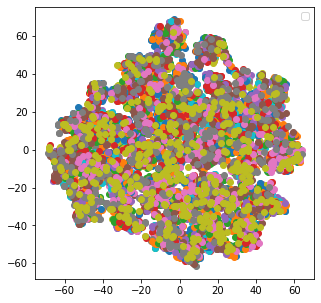

In [42]:
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(embeddings)
positive_list = []
for i in range(len(np.unique(pretrain_dataset[:,0]))) :
    positive_list.append(pretrain_dataset[:,0] == i)

fig, ax = plt.subplots(figsize=(5, 5))

for positive in positive_list :
    ax.scatter(reduced[positive, 0], reduced[positive, 1])
#ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()

## tSNE with different embedding dimension

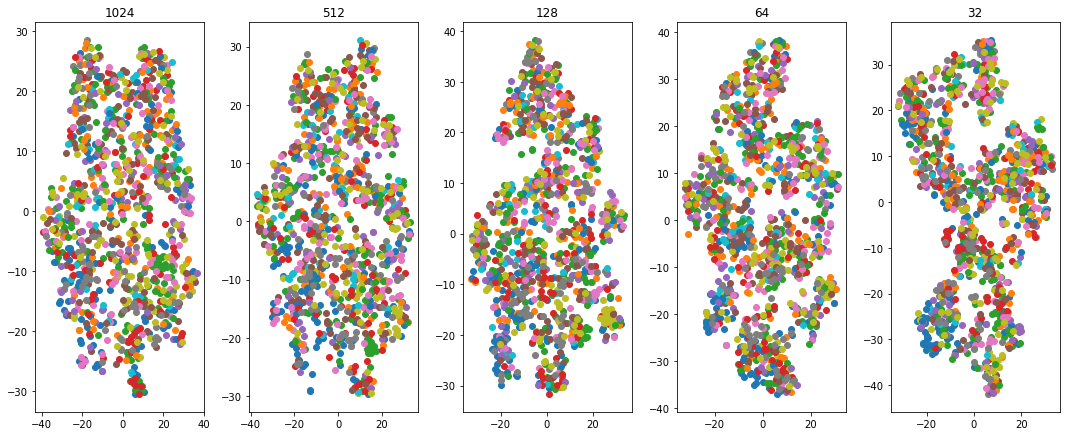

In [41]:
# DataLoaders
train_loader = DataLoader(x_train, batch_size=bs, shuffle=False, drop_last=False)
#val_loader = DataLoader(x_val_tmp, batch_size=bs, shuffle=True, drop_last=True)
test_loader = DataLoader(x_test, batch_size=bs, shuffle=False, drop_last=False)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 6))
fig.tight_layout()
ax_list = [ax1, ax2, ax3, ax4, ax5]

for ax, emb_dim in zip(ax_list, [1024, 512, 128, 64, 32]) :
    # load encoder
    encoder = SCARF(
                input_dim=x_unlabel.shape[1],
                emb_dim=emb_dim, # 16 by default, augment in the future
                features_low=x_unlabel.min(axis=0),
                features_high=x_unlabel.max(axis=0),
                nb_classes=nb_classes,
                num_hidden=4,
                corruption_rate=corruption_rate,
                dropout=dropout
            ).to(device)
            
    encoder.load_state_dict(torch.load(f"saved_models/scarf_encoder_{emb_dim}emb_4enc_statedict_1000epochs.pt"), strict=False)
    
    # get embeddings
    train_embeddings = dataset_embeddings(encoder, train_loader, device)
    #val_embeddings = dataset_embeddings(encoder, val_loader, device)
    test_embeddings = dataset_embeddings(encoder, test_loader, device)
    
    tsne = TSNE(n_components=2)
    reduced = tsne.fit_transform(train_embeddings)
    positive_list = []
    for i in range(len(np.unique(y_train))) :
        positive_list.append(y_train == i)

    #fig, ax = plt.subplots(figsize=(5, 5))

    for positive in positive_list :
        ax.scatter(reduced[positive, 0], reduced[positive, 1])
    #ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
    #plt.title(f'{emb_size} embedding size')
    
    
#ax1.plot(x, y)
#fig.suptitle('tSNE with different embedding dimension')
ax1.set_title(f'1024')
ax2.set_title(f'512')
ax3.set_title(f'128')
ax4.set_title(f'64')
ax5.set_title(f'32')
plt.savefig('figures/comp_embsize.png')

## tSNE with different architecture

In [8]:
encoder = SCARF_modified(
                input_dim=x_unlabel.shape[1],
                emb_dim=64, # 16 by default, augment in the future
                features_low=x_unlabel.min(axis=0),
                features_high=x_unlabel.max(axis=0),
                nb_classes=nb_classes,
                num_hidden=64,
                corruption_rate=corruption_rate,
                dropout=dropout
            ).to(device)
            
encoder.load_state_dict(torch.load('saved_models/scarf_encoder_modified_statedict_1000epochs.pt'), strict=False)

NameError: name 'nb_classes' is not defined